In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import math

In [32]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ImageFolder("data/dog_dataset/", transform=transform)
loader = DataLoader(dataset, batch_size=8, shuffle=True)



In [33]:
print("Dataset size:", len(dataset))
print("Classes:", dataset.classes)

x, y = dataset[0]
print("Image shape:", x.shape)
print("Label:", y)

Dataset size: 33
Classes: ['dog']
Image shape: torch.Size([3, 64, 64])
Label: 0


In [34]:
T = 1000

betas = torch.linspace(1e-4, 0.02, T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

In [35]:
def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)

    sqrt_alpha_bar = alphas_cumprod[t] ** 0.5
    sqrt_one_minus = (1 - alphas_cumprod[t]) ** 0.5

    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise

In [36]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Linear(1, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, t):
        return self.embed(t.unsqueeze(-1).float())

In [37]:
class TinyDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embed = TimeEmbedding(32)

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_embed(t / T).view(-1, 32, 1, 1)

        h = self.conv1(x)
        h = h + t_emb
        h = F.relu(h)

        h = F.relu(self.conv2(h))
        return self.conv3(h)

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyDenoiser().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    for x, _ in loader:
        x = x.to(device)

        t = torch.randint(0, T, (x.size(0),), device=device)
        noise = torch.randn_like(x)

        x_noisy = torch.stack([
            q_sample(x[i], t[i], noise[i])
            for i in range(x.size(0))
        ])

        pred_noise = model(x_noisy, t)
        loss = F.mse_loss(pred_noise, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

    print(f"epoch {epoch} loss {loss.item():.4f}")

epoch 0 loss 0.9488
epoch 1 loss 0.8026
epoch 2 loss 0.4999
epoch 3 loss 0.3239
epoch 4 loss 0.4457
epoch 5 loss 0.1343
epoch 6 loss 0.1064
epoch 7 loss 0.0853
epoch 8 loss 0.0820
epoch 9 loss 0.2601
epoch 10 loss 0.0743
epoch 11 loss 0.0593
epoch 12 loss 0.1334
epoch 13 loss 0.0551
epoch 14 loss 0.0500
epoch 15 loss 0.0510
epoch 16 loss 0.0484
epoch 17 loss 0.0495
epoch 18 loss 0.0483
epoch 19 loss 0.0476


In [39]:
@torch.no_grad()
def sample(model, shape):
    x = torch.randn(shape).to(device)

    for t in reversed(range(T)):
        pred_noise = model(x, torch.tensor([t], device=device))
        alpha = alphas[t]
        alpha_bar = alphas_cumprod[t]

        x = (1 / alpha**0.5) * (
            x - (1 - alpha) / (1 - alpha_bar)**0.5 * pred_noise
        )

        if t > 0:
            x += betas[t]**0.5 * torch.randn_like(x)

    return x

In [44]:
samples = sample(model, (4, 3, 64, 64))

In [45]:
samples = (samples + 1) / 2
samples = samples.clamp(0, 1)

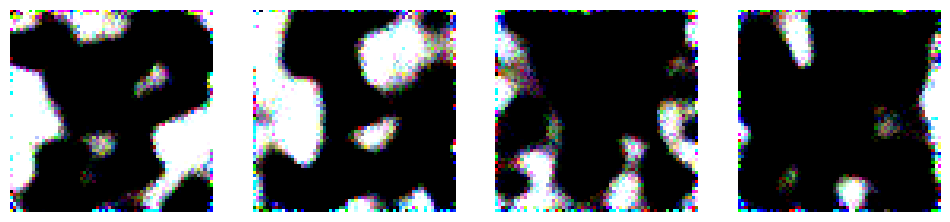

In [46]:
import matplotlib.pyplot as plt

grid = samples.cpu().permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, grid.size(0), figsize=(12, 3))
for i, ax in enumerate(axs):
    ax.imshow(grid[i])
    ax.axis("off")

plt.show()

In [47]:
from torchvision.utils import save_image

save_image(samples, "generated.png", nrow=4)